# 1.0 Derivadas

En el metodo Smoothed-particle hydrodynamics (SPH) se emplean diferentes kernel de aproximación para calcular las propiedades de un fluído en cada punto del espacio. Uno de ellos es el Kernel de Lucy detallado a continuación:

\begin{equation}
W(R, h)= \alpha_D \left\{
  \begin{matrix} \left(1+3q)(1- q\right)^3 &  0\leq q \leq h \\ 
  0 & in\ the\ other\ case.
  \end{matrix}
\right.
\end{equation}

en donde: 
\begin{equation}
q=\frac{|(\vec{r}-\vec{r}')|}{h}
\end{equation}


y  $\alpha_D$ es la constante de normalización:

en 2 dimensiones, viene dada por:
 
\begin{equation}
\alpha_D = \frac{5}{\pi h^2}
\end{equation}






Para el kernel de Lucy en 2D encontrar su derivada a través de los siguientes pasos:
###  1. Realizar un gráfico del kernel de Lucy.

Vamos a programar una función en numpy para esto: 

In [356]:
import numpy as np
from matplotlib import pyplot as plt

def W(r):
    h=1
    α = 5 / (np.pi * h**2)
    k = np.zeros((len(r)))
    
    for i in range(0,len(r)):
        q = np.abs(r[i] / h) 
        if q >=0 and q<=h:
            k[i] = α * (1+3*q)*(1-q)**3
        else:
            k[i] = 0
    return k


Text(0.5, 1.0, 'kernel de lucy')

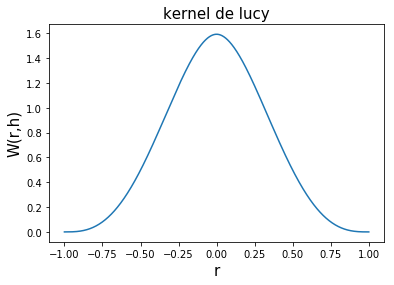

In [357]:
r = np.linspace(-1,1,1000)

plt.plot(r,W(r))
plt.xlabel('r',size=15)
plt.ylabel('W(r,h)',size=15)
plt.title('kernel de lucy',size=15)


### 2.Encontrar la derivada empleanda la libreria simbolica


\begin{equation}
W(R, h)= \left\{
  \begin{matrix}  (\frac{5}{\pi h^{2}})(1+3 |\frac{r}{h}|)(1- |\frac{r}{h}|)^3 &  0\leq q< h \\ 
  0 & in\ the\ other\ case.
  \end{matrix}
\right.
\end{equation}

Primero vamos a redifinir las expresiones y reemplazarlas en la formula para que quede en terminos enteramente de R y h 

In [358]:
import sympy as sp 
from scipy.misc import derivative as Derivative
h = 1
r = sp.Symbol('r', real=True)
W_s = (5/(sp.pi*h**2)) * (1+ 3*(sp.Abs(r/h))) * (1-(sp.Abs(r/h)))**3
W_s

5*(1 - Abs(r))**3*(3*Abs(r) + 1)/pi

In [359]:
sp.diff(W_s,r)

15*(1 - Abs(r))**3*sign(r)/pi - 15*(1 - Abs(r))**2*(3*Abs(r) + 1)*sign(r)/pi

In [360]:
derivada = sp.lambdify(r,sp.diff(W_s,r))
derivada = np.vectorize(derivada)

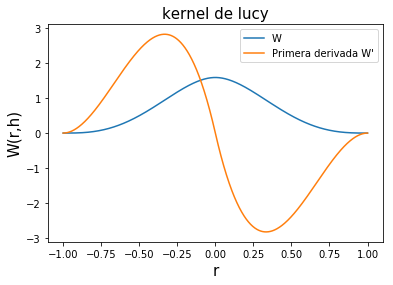

In [361]:
h = 1
r = np.linspace(-1,1,1000)

plt.plot(r,W(r), label = 'W')
plt.plot(r,derivada(r), label = "Primera derivada W'")
plt.xlabel('r',size=15)
plt.ylabel('W(r,h)',size=15)
plt.title('kernel de lucy',size=15)
plt.legend()


### 3. Realizar un grafico de los cálculos encontrados con la libreria simbólica y comparar con la derivada numérica de los datos del punto 1.


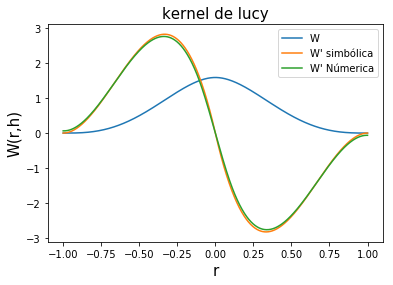

In [382]:
# from scipy.misc import derivative

derivada_numerica = np.vectorize(derivative)

def W_1(r,dx=0.1):
    h=1
    q=np.abs(r/h)
    k = lambda r: (5 / (np.pi * h**2) ) * (1 + 3 * np.abs(r/h)) * (1- np.abs(r/h))**3
    k = derivada_numerica(k,r,dx=dx)
    
    for i in range(0,len(r)):
        if q[i] >=0 and q[i]<=h:
            'no_restriction'
        else:
            k[i] = 0
    return k
    

plt.plot(r,W(r), label = 'W')
plt.plot(r,derivada(r), label = "W' simbólica")
plt.plot(r,W_1(r),label= "W' Númerica")
plt.xlabel('r',size=15)
plt.ylabel('W(r,h)',size=15)
plt.title('kernel de lucy',size=15)
plt.legend()



Si se utiliza un valor de dx más pequeño en la derivada númerica se puede lograr una precisión incluso mayor:

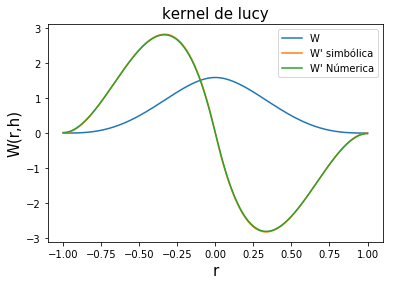

In [384]:

plt.plot(r,W(r), label = 'W')
plt.plot(r,derivada(r), label = "W' simbólica")
plt.plot(r,W_1(r,0.05),label= "W' Númerica")
plt.xlabel('r',size=15)
plt.ylabel('W(r,h)',size=15)
plt.title('kernel de lucy',size=15)
plt.legend()

# 2.0 Integración

### Escribir en código Markdown la expresión para calcular una integral con la regla del trapecio.



Vamos a escribir la expresión correspondiente para "composite trapezoidal rule" la cual está implementada en scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapezoid.html

La expresión en cuestión está dada por: 

\begin{equation}
\int_{a}^{b} f(x)dx = \sum_{i=0}^{N-1} \int_{i}^{x_{i+1}} f(x)dx = \frac{h}{2}\sum_{i=0}^{N-1} (f(x_{i}) + f(x_{i+1})) - \frac{(b-a)h^{2}}{12}f''(\xi)
\end{equation}

En donde el error viene dado por la expresión: 

\begin{equation}
\epsilon = {\frac{(b-a)h^{2}}{12}f''(\xi)}
\end{equation}

Para determinar la presición deseada  $\epsilon$ vamos a necesitar escoger el valor adecuado de $h$, por tanto, podemos despejarla de la ecuación y tenemos que: 

\begin{equation}
h =  \sqrt{\frac{12 \epsilon}{(b-a) f''(\xi)}}
\end{equation}

Vamos a crear una función para calcular h para la regla del trapezio, y a su vez, para calcular el número de puntos necesarios teniendo en cuenta que

\begin{equation}
n = \frac{b-a}{h}
\end{equation}

In [1]:
def h_trapezio(ϵ,a,b,f):
    num = 12*ϵ
    dem = (b-a)*abs(f)
    h= np.sqrt(num/dem)
    n = (b-a)/h
    return h,n

Sin embargo también se observa que se debe calcular el valor máximo de $f''(\xi)$, para esto utilizaremos el modulo de sympy. con esto podemos obtener las derivadas de orden n, y luego calcular el valor maximo de la n-sima derivada, derivandola una vez más y convirtiendola a función de numpy, con uno de los métodos vistos para encontrar raices  $f''(\xi)$ en el intervalo.  

In [2]:
def max_order(f : 'sympy expresion', n:'order of the derivate', a, b, init_point, plot=False):
    
    der_n = sp.diff(f,x,n)
    der_n_1 = sp.diff(f,x,n+1)
    f = sp.lambdify(x,f)
    f_n = sp.lambdify(x,der_n)
    f_n_1 = sp.lambdify(x,der_n_1)
    
    
    t = np.linspace(a,b,500)
    
    if plot == True:
        fig,axs = plt.subplots(1,2,figsize=(15,5))
        axs[0].plot(t,f(t))
        axs[0].set_title('$f(x)$', size=20)
        axs[0].set_xlabel('$x$',size=15)
        axs[0].set_ylabel('$f(x)$',size=15)

        axs[1].plot(t,f_n(t))
        axs[1].set_title("$f^{}(x)$".format(n), size=20)
        axs[1].set_xlabel('$x$',size=15)
        axs[1].set_ylabel("$f^{}(x)$".format(n),size=15)
    
    max_f = optimize.newton(f_n_1,init_point)
    
    return f, f_n(max_f)



### Escribir en código Markdown la expresión para calcular una integral con la regla del simpson.



En este caso escribimos la expresión para la regla de Simpson compuesta, la cual está implementada en scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simpson.html. 
La expresión está dada por: 

\begin{equation}
\int_{a}^{b} f(x)dx = \frac{h}{3}\left[f_{0} + 2 \sum_{i=1}^{N-1}f_{2i} +4\sum_{i=1}^{N} f_{2i-1} + f_{2N}  \right] - \frac{(b-a)h^{4}}{180} f^{(4)}(\xi)
\end{equation}

En donde el error viene dado por la expresión: 

\begin{equation}
\epsilon =  \frac{(b-a)h^{4}}{180} f^{(4)}(\xi)
\end{equation}

Ahora se escribe la expresión de h para el método de simpson: 


\begin{equation}
h =  \sqrt[4]{\frac{180 \epsilon}{(b-a)f^{4}(\xi)}}
\end{equation}



In [3]:
def h_simpson(ϵ,a,b,f):
    num = 180*ϵ
    dem = (b-a)*abs(f)
    h= (num/dem)**(1/4)
    n = (b-a)/h
    return h,n

### Escribir en código Markdown la expresión para calcular una integral con el metodo de cuadratura.



En este caso como se acordó en clase, no se describira la expresión del método, sino que se utilizara el método de cuadratura adaptativo que viene implementado en scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html
Dado que este nos proporciona directamente el error en el calculo de la integral, es bueno para comparar con los otros métodos. 

### Calcular una aproximación con el metodo 1,2,3 de las siguientes integrales: 



* \begin{equation}
\int_{0}^{\pi} e^{1-\sqrt{x}} dx
\end{equation}

In [393]:
import numpy as np 
from matplotlib import pyplot as plt
import sympy as sp
from scipy import optimize
from scipy import integrate

Creamos la función: 

In [5]:
# Para comparar tenemos el valor de la integral exacto. 
true_value = 2.875491135437584
x = sp.Symbol('x')
f1 = sp.exp(1-sp.sqrt(x))
f1

exp(1 - sqrt(x))

### Método de trapecio:

Se procede a graficarla y a encontrar un valor aproximado para el valor máximo de la segunda derivada en el intervalo $[a,b]$

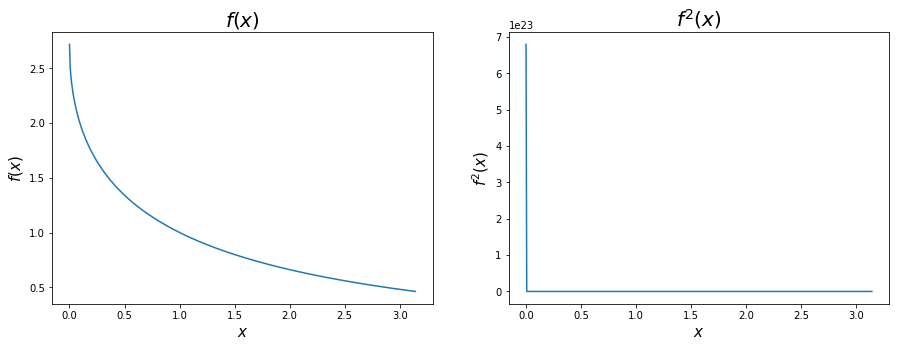

In [6]:
f1_numpy, f_1_max = max_order(f=f1, n=2, a=1e-16, b=np.pi , init_point= 1e-16, plot=True)

Con esto podemos encontrar el valor de h y n: 

In [7]:
h,n = h_trapezio(ϵ = 1e-5, a=1e-16, b=np.pi, f=f_1_max)
h

7.497374882459643e-06

Ahora podemos calcular la integral entre el intervalo $[0,\pi]$: 

In [8]:
t = np.linspace(1e-16,np.pi,int(n)+1)
y = f1_numpy(t)
trap = integrate.trapz(y,t)
trap

2.8754911470312314

### Regla de Simpson

Repetimos el mismo procedimiento cambiando el orden de la derivada y usando la función para h de simpson:

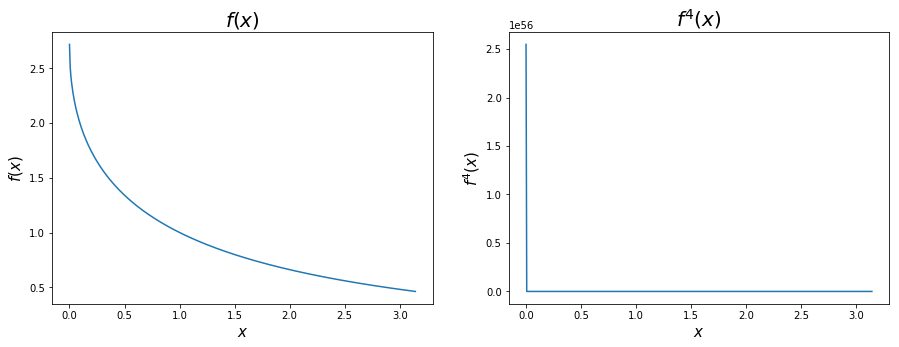

In [9]:
f1_numpy, f1_max = max_order(f=f1, n=4, a=1e-16, b=np.pi , init_point= 1e-16,plot=True)

In [10]:
h,n = h_simpson(ϵ = 1e-5, a=1e-16, b=np.pi, f=f1_max)
h

3.872267081848673e-05

In [11]:
t = np.linspace(1e-16,np.pi,int(n)+1)
y = f1_numpy(t)
sim = integrate.simps(y,t)
sim

2.875491188613807

In [12]:
# cuadratura 
quad = integrate.quad(f1_numpy,1e-16,np.pi)
quad

(2.8754911354375863, 1.982122022070598e-09)

In [13]:
print('Metodo: Trapecio, valor = {:.16f}, error = {} '.format(trap,abs(true_value-trap)))
print('Metodo: Simpson,  valor = {:.16f}, error = {} '.format(sim,abs(true_value-sim)))
print('Metodo: Cuadratura,  valor = {:.16f}, error = {} '.format(quad[0],quad[1]))

Metodo: Trapecio, valor = 2.8754911470312314, error = 1.1593647375462979e-08 
Metodo: Simpson,  valor = 2.8754911886138070, error = 5.3176222980511056e-08 
Metodo: Cuadratura,  valor = 2.8754911354375863, error = 1.982122022070598e-09 


* \begin{equation}
\int_{0}^{\pi/2} \frac{1}{\sqrt{tan(x)}}
\end{equation} 

In [31]:
true_value = 2.221441469079183
a = 1e-8
b = np.pi/2  
x = sp.Symbol('x')
f1 = 1/sp.sqrt(sp.tan(x))

# Trapecio
f1_numpy, f_1_max = max_order(f=f1, n=2, a=a, b=b , init_point= 1e-16)
h, n = h_trapezio(ϵ = 1e-5, a=a, b=b, f=f_1_max)
t = np.linspace(a,b,int(n)+1)
y = f1_numpy(t)
trap = integrate.trapz(y,t)

# simpson
f1_numpy, f_1_max = max_order(f=f1, n=4, a=a, b=b , init_point= 1e-16)
h, n = h_simpson(ϵ = 1e-5, a=a, b=b, f=f_1_max)
t = np.linspace(a,b,int(n)+1)
y = f1_numpy(t)
sim = integrate.simps(y,t)


# cuadratura
quad = integrate.quad(f1_numpy, a,b)


print('Metodo: Trapecio, valor = {:.16f}, error = {} '.format(trap,abs(true_value-trap)))
print('Metodo: Simpson,  valor = {:.16f}, error = {} '.format(sim,abs(true_value-sim)))
print('Metodo: Cuadratura,  valor = {:.16f}, error = {} '.format(quad[0],quad[1]))


Metodo: Trapecio, valor = 2.2214425121270769, error = 1.043047893833915e-06 
Metodo: Simpson,  valor = 2.2213836601575010, error = 5.7808921682056535e-05 
Metodo: Cuadratura,  valor = 2.2214414693812601, error = 2.3835832418939162e-08 


* \begin{equation}
\int_{-\infty}^{\infty} \frac{1}{1+x^{2}}
\end{equation} 

In [15]:
x = sp.Symbol('x')
f1 = 1/(1+ x**2)
f1

1/(x**2 + 1)

En este caso tenemos que graficar la función para poder determinar unos valores de a,b finitos en los cuales el aporte a partir de estos puntos a la integral sea despreciable. 

Text(0, 0.5, 'f(x)')

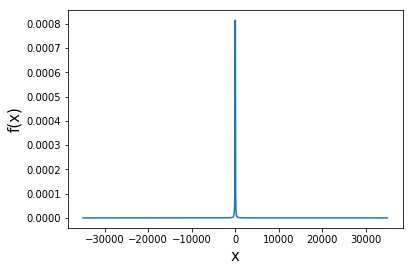

In [16]:
true_value = np.pi
a = -35000
b = 35000
f1_numpy = sp.lambdify(x,f1)
t = np.linspace(a,b,1000)
plt.plot(t,f1_numpy(t))
plt.xlabel('x',size=15)
plt.ylabel('f(x)',size=15)

Vemos que con estos valores de a,b ya podemos calcular la integral con una buena presición, ya que los terminos más alla del limite del intervalo tanto por derecha, como por izquierda convergen a 0. Sin embargo este intervalo es demasiado grande y se pueden presentar problemas de memoria si se va realizar el cálculo de una vez. Pero dado que la función es continua en todo $R$, y ademas es una función par, podemos ver la integral como: 

* \begin{equation}
\int_{-\infty}^{\infty} \frac{1}{1+x^{2}} = 2 \int_{0}^{\infty} \frac{1}{1+x^{2}}
\end{equation} 

In [17]:
a= 0
b = 35000

# Trapecio 
f1_numpy, f_1_max = max_order(f=f1, n=2, a=a, b=b , init_point= 0)
h, n = h_trapezio(ϵ = 1e-5, a=a, b=b, f=f_1_max)
n = n/2 # Ya que la integral se parte en dos, el numero de intervalos se reduce a la mitad
t = np.linspace(a,b,int(n)+1)
y = f1_numpy(t)
trap = integrate.trapz(y,t)

In [18]:
# simpson 
# Los metodos de simpson y cuadratura requieren menos recursos computacionales que trapecio, por tanto fue posible aumentar
# los valores extremos del intervalo
a= 0
b = 500000
f1_numpy, f_1_max = max_order(f=f1, n=4, a=a, b=b , init_point= 0) 
h, n = h_simpson(ϵ = 1e-5, a=a, b=b, f=f_1_max)
n = n/2 # Ya que la integral se parte en dos, el numero de intervalos se reduce a la mitad
t = np.linspace(a,b,int(n)+1)
y = f1_numpy(t)
sim = integrate.simps(y,t)

In [19]:
# cuadratura 1
a= 0
b = 100000
quad = integrate.quad(f1_numpy, a,b)

In [20]:
print('Metodo: Trapecio, valor = {:.16f}, error = {} '.format(trap*2,abs(true_value-(trap*2))))
print('Metodo: Simpson,  valor = {:.16f}, error = {} '.format(sim*2,abs(true_value-(sim*2))))
print('Metodo: Cuadratura,  valor = {:.16f}, error = {} '.format(quad[0]*2,quad[1]*2))

Metodo: Trapecio, valor = 3.1415355107326497, error = 5.714285714342182e-05 
Metodo: Simpson,  valor = 3.1415886535898112, error = 3.999999981907365e-06 
Metodo: Cuadratura,  valor = 3.1415726535898214, error = 3.1882986530301465e-08 


* \begin{equation}
\int_{0}^{\pi/4} \int_{sinx}^{cosx} (2ysinx+cos^{2}x) dydx
\end{equation}

En donde:  
$ sinx \leq y \leq cosx $   
$ 0 \leq x \leq \frac{\pi}{4}$



En este caso tenemos la gran ventaja de que el metodo de cuadratura nos permite calcular integrales dobles, sin embargo, para los métodos de trapecio y Simpson debemos plantear el problema de otra forma. Primero realicemos el problema con el método de cuadratura: 

In [21]:
true_value = 0.5118446353109125
f1_numpy = lambda y,x: 2*y*np.sin(x) + (np.cos(x))**2

In [22]:
quad = integrate.dblquad(f1_numpy,0,np.pi/4, lambda x: np.sin(x), lambda x: np.cos(x))
quad

(0.5118446353109126, 1.1102181755259596e-14)

Ahora, para los métodos de trapezio y Simpson vamos a fijar un valor de x en el intervalo $[0,\frac{\pi}{4}]$ y evaluar los valores de x en ese intervalo, luego integrar respecto a y y evaluar. Si sumamos todos los resultados que se obtienen variando la x en todo el intervalo tendriamos la aproximación de la integral doble: 

In [23]:
x = np.linspace(0,np.pi/4,20000)
dx = np.pi/(4*20000)
suma_trapecio = 0
for i in x: 
    t = np.linspace(np.sin(i), np.cos(i),20000)
    y = f1_numpy(t,i)
    suma_trapecio += integrate.trapz(y,t) * dx
    
suma_trapecio

0.5118386777606062

In [25]:
x = np.linspace(0,np.pi/4,15000)
dx = np.pi/(4*15000)
suma_Simpson = 0
for i in x: 
    t = np.linspace(np.sin(i), np.cos(i),15000)
    y = f1_numpy(t,i)
    suma_Simpson += integrate.simps(y,t) * dx 

suma_Simpson

0.5118366917893316

In [26]:
print('Metodo: Trapecio, valor = {:.16f}, error = {} '.format(suma_trapecio,abs(true_value-suma_trapecio)))
print('Metodo: Simpson,  valor = {:.16f}, error = {} '.format(suma_Simpson,abs(true_value-suma_Simpson)))
print('Metodo: Cuadratura,  valor = {:.16f}, error = {} '.format(quad[0],quad[1]))

Metodo: Trapecio, valor = 0.5118386777606062, error = 5.957550306301407e-06 
Metodo: Simpson,  valor = 0.5118366917893316, error = 7.943521580955348e-06 
Metodo: Cuadratura,  valor = 0.5118446353109126, error = 1.1102181755259596e-14 


* \begin{equation}
\int_{e}^{2e} \frac{1}{ln(x)} dx
\end{equation}

In [27]:
true_value =2.003810561624024
a = np.exp(1)
b = 2*np.exp(1)
x = sp.Symbol('x')
f1 = 1/sp.ln(x)

Text(0, 0.5, '$f^4(x)$')

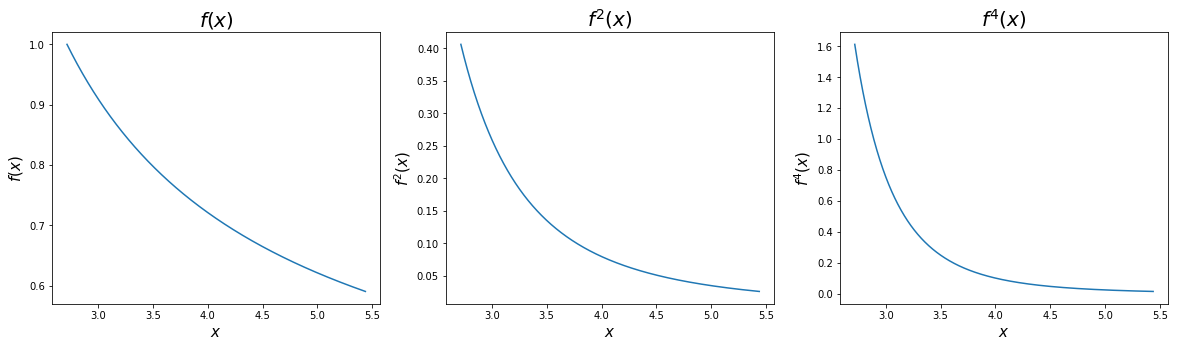

In [28]:
# Veamos la función y sus derivadas

t = np.linspace(a,b,1000)

f = sp.lambdify(x,f1)
f1_numpy = f
der_2 = sp.diff(f1,x,2)
der_4 = sp.diff(f1,x,4)
f_2 = sp.lambdify(x,der_2)
f_4 = sp.lambdify(x,der_4)


fig,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(t,f(t))
axs[0].set_title('$f(x)$', size=20)
axs[0].set_xlabel('$x$',size=15)
axs[0].set_ylabel('$f(x)$',size=15)

axs[1].plot(t,f_2(t))
axs[1].set_title("$f^{}(x)$".format(2), size=20)
axs[1].set_xlabel('$x$',size=15)
axs[1].set_ylabel("$f^{}(x)$".format(2),size=15)

axs[2].plot(t,f_4(t))
axs[2].set_title("$f^{}(x)$".format(4), size=20)
axs[2].set_xlabel('$x$',size=15)
axs[2].set_ylabel("$f^{}(x)$".format(4),size=15)



En este caso no hay un máximo local o global de las derivadas en el intervalo, por lo tanto simplemente tomamos
el extremo izquierdo como máximo, ya que este es el punto donde es máximo el valor la función en ese intervalo. 

In [29]:
# Trapecio
h, n = h_trapezio(ϵ = 1e-6, a=a, b=b, f=f_2(a))
t = np.linspace(a,b,int(n)+1)
y = f1_numpy(t)
trap = integrate.trapz(y,t)

# simpson
h, n = h_simpson(ϵ = 1e-6, a=a, b=b, f=f_4(a))
t = np.linspace(a,b,int(n)+1)
y = f1_numpy(t)
sim = integrate.simps(y,t)

# cuadratura
quad = integrate.quad(f1_numpy, a,b)

print('Metodo: Trapecio, valor = {:.16f}, error = {} '.format(trap,abs(true_value-trap)))
print('Metodo: Simpson,  valor = {:.16f}, error = {} '.format(sim,abs(true_value-sim)))
print('Metodo: Cuadratura,  valor = {:.16f}, error = {} '.format(quad[0],quad[1]))



Metodo: Trapecio, valor = 2.0038108370602865, error = 2.75436262686668e-07 
Metodo: Simpson,  valor = 2.0038201580543542, error = 9.596430330383043e-06 
Metodo: Cuadratura,  valor = 2.0038105616240243, error = 2.2246766225020577e-14 


# Velocidad de escape:
Suppose a body of mass m is traveling vertically upward starting at the surface of the earth. If all resistance except gravity is neglected, the escape velocity v is given by: 

\begin{equation}
v^2=2gR\int_1 ^\infty z^{-2} dz
\end{equation}
where z=x/R, R is the earth radius and g de gravity aceleration. Approximate the scape velocity


In [409]:
R = 6378 # metros
g = 9.8 # metros/s^2

z = lambda z: z**-2

integral = integrate.quad(z,1,np.inf)

velocidad_de_escape = np.sqrt(2*g*R*integral[0]/1000) # dividimos por 1000 para que quede en unidades de km/s

print('La velocidad de escape es: {} km/s'.format(velocidad_de_escape))

La velocidad de escape es: 11.180733428536788 km/s


# 6

Write a double precision program to integrate an arbitrary function numerically using the trapezoid rule, the Simpson rule, and Gaussian quadrature. For our assumed problems there is an analytics answer:


\begin{equation}
\frac{\mathrm{d}N(t)}{\mathrm{d}t}=e^{-t}
\end{equation}

\begin{equation}
N(1)=\int_0^{1}e^{-t} dt=1-e^{-1}
\end{equation}




In [295]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
import pandas as pd

def integration(f, a, b): 
    t = np.linspace(a,b,1000)
    y = f(t)
    trap = integrate.trapz(y,t)
    simp = integrate.simps(y,t)
    gauss = integrate.quadrature(f,a,b, rtol=1.49e-5,miniter=10)
    
    return trap,simp,gauss[0]
   

Text(0.5, 1.0, 'f(t) vs t')

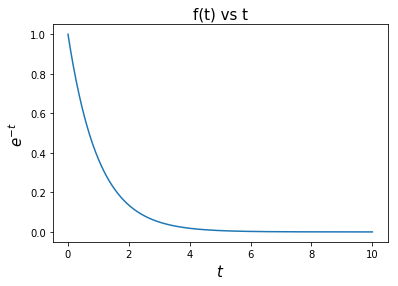

In [296]:
t = np.linspace(0,10,1000)
f = lambda t: np.exp(-t)
plt.plot(t,f(t))
plt.xlabel('$t$', size=15)
plt.ylabel('$e^{-t}$', size=15)
plt.title('f(t) vs t', size=15)

In [297]:
integration(f,0,1)

(0.6321206116107817, 0.6321205588857143, 0.6321205588285578)

6.2. Compute the relative error $\epsilon=|numerical-exact|/exact$  in each case. Present your data in the tabular form with space or tabas seprating the field. Try N values of 2, 10, 20 , 40 , 80, 160

Vamos a crear una función para calcular el error relativo: 

In [298]:
def error(a,b,args):
    
    exact_value = -np.exp(-b) + np.exp(-a)
    
    relative_error = np.zeros(3)
    count=0
    
    for i in args:
        relative_error[count] = np.abs(i-exact_value)/exact_value
        count += 1
    return relative_error
    

Definimos los valores de N y calculamos el error para cada caso: 

In [299]:
N = [2,10,20,40,80,160]
df = pd.DataFrame(columns=['N', '$\epsilon_{T}$', '$\epsilon_{S}$', '$\epsilon_{G}$' ])


In [300]:
for j in N: 
    integrales = integration(f,0,j)
    relative = error(0,j,integrales)
    a_series = pd. Series(np.r_[j,relative], index = df. columns)
    df = df. append(a_series, ignore_index=True)

In [301]:
df['N'] = df['N'].astype('int')
df

,N,$\epsilon_{T}$,$\epsilon_{S}$,$\epsilon_{G}$
0,2,3.340010e-07,4.387487e-10,1.283993e-16
1,10,8.350011e-06,4.164267e-08,6.672743e-14
2,20,3.339988e-05,3.318922e-07,8.202491e-09
3,40,1.335968e-04,2.635769e-06,9.220737e-07
4,80,5.343445e-04,2.078044e-05,1.226567e-06
5,160,2.136693e-03,1.614822e-04,5.779371e-06


6.3. Make a log-log plot of relative errore versus. You should observe that $\epsilon\approx CN^{\alpha}$ 
, $\mathrm{log} \epsilon =\alpha \mathrm{log}N + \mathrm{constant}$. This mean that a power-law dependence appears as a straight line on a log-log plot, and that if you use 
$\log_{10}$, the the ordinate on your log-log plot will be the negative of the numver of decimal places of presicion in your calculation.

Text(0, 0.5, '$log_{10}(\\epsilon_{T})$')

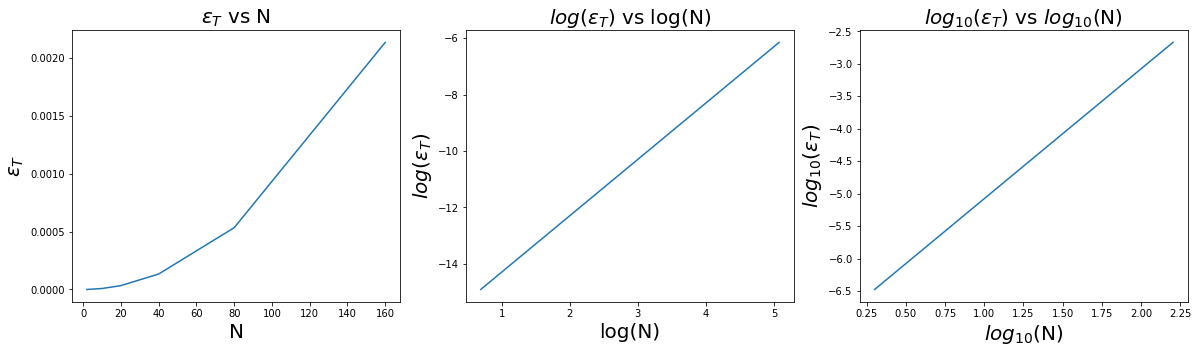

In [323]:
fig,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(df.N, df['$\epsilon_{T}$'])
axs[0].set_title('$\epsilon_{T}$ vs N', size=20)
axs[0].set_xlabel('N',size=20)
axs[0].set_ylabel('$\epsilon_{T}$',size=20)

axs[1].plot(np.log(df.N), np.log(df['$\epsilon_{T}$']))
axs[1].set_title('$log(\epsilon_{T})$ vs log(N)', size=20)
axs[1].set_xlabel('log(N)',size=20)
axs[1].set_ylabel('$log(\epsilon_{T})$',size=20)


axs[2].plot(np.log10(df.N), np.log10(df['$\epsilon_{T}$']))
axs[2].set_title('$log_{10}(\epsilon_{T})$ vs $log_{10}$(N)', size=20)
axs[2].set_xlabel('$log_{10}$(N)',size=20)
axs[2].set_ylabel('$log_{10}(\epsilon_{T})$',size=20)


Text(0, 0.5, '$log_{10}(\\epsilon_{S})$')

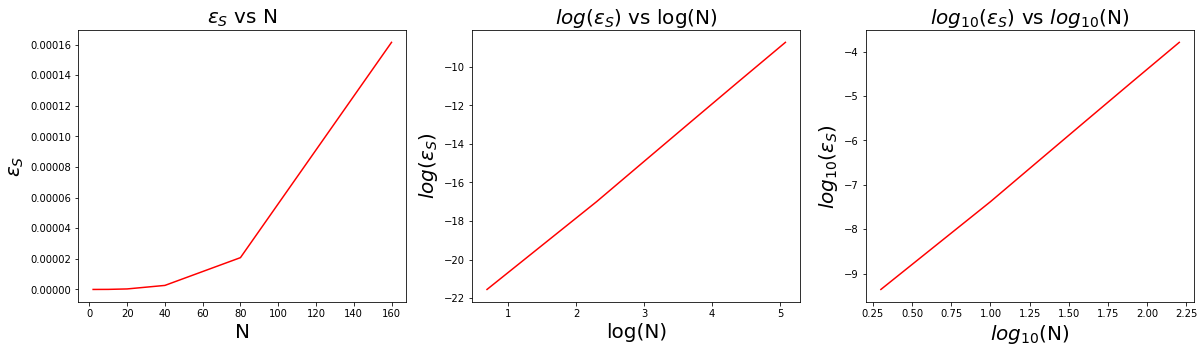

In [319]:
fig,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(df.N, df['$\epsilon_{S}$'],'r')
axs[0].set_title('$\epsilon_{S}$ vs N', size=20)
axs[0].set_xlabel('N',size=20)
axs[0].set_ylabel('$\epsilon_{S}$',size=20)


axs[1].plot(np.log(df.N), np.log(df['$\epsilon_{S}$']),'r')
axs[1].set_title('$log(\epsilon_{S})$ vs log(N)', size=20)
axs[1].set_xlabel('log(N)',size=20)
axs[1].set_ylabel('$log(\epsilon_{S})$',size=20)

axs[2].plot(np.log10(df.N), np.log10(df['$\epsilon_{S}$']),'r')
axs[2].set_title('$log_{10}(\epsilon_{S})$ vs $log_{10}$(N)', size=20)
axs[2].set_xlabel('$log_{10}$(N)',size=20)
axs[2].set_ylabel('$log_{10}(\epsilon_{S})$',size=20)


Text(0, 0.5, '$log_{10}(\\epsilon_{G})$')

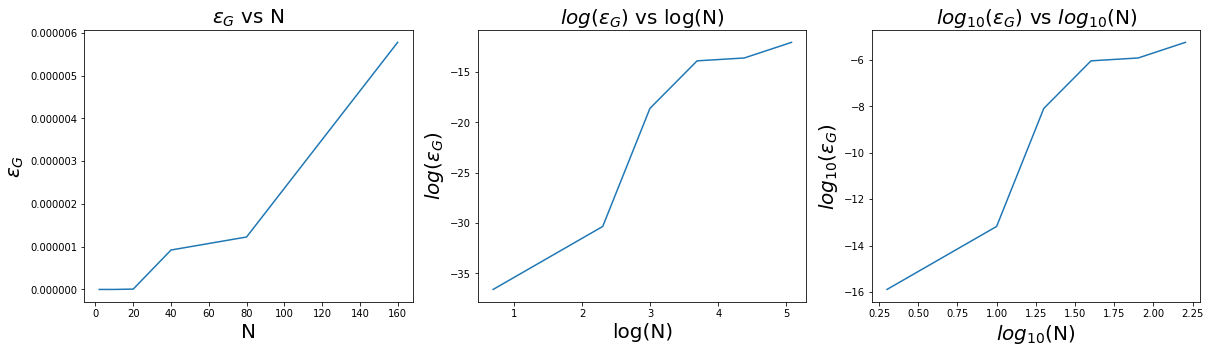

In [307]:
fig,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(df.N, df['$\epsilon_{G}$'])
axs[0].set_title('$\epsilon_{G}$ vs N', size=20)
axs[0].set_xlabel('N',size=20)
axs[0].set_ylabel('$\epsilon_{G}$',size=20)

axs[1].plot(np.log(df.N), np.log(df['$\epsilon_{G}$']))
axs[1].set_title('$log(\epsilon_{G})$ vs log(N)', size=20)
axs[1].set_xlabel('log(N)',size=20)
axs[1].set_ylabel('$log(\epsilon_{G})$',size=20)

axs[2].plot(np.log10(df.N), np.log10(df['$\epsilon_{G}$']))
axs[2].set_title('$log_{10}(\epsilon_{G})$ vs $log_{10}$(N)', size=20)
axs[2].set_xlabel('$log_{10}$(N)',size=20)
axs[2].set_ylabel('$log_{10}(\epsilon_{G})$',size=20)


6.4. Use your plot or table to stimate the power-law dependence of the error  on the number of points N and to determine the number of decimal places of presicion in your calculation. Do this for both the trapezoid and simpsons rules and for both the algolrithmic and round-off error regimes. (Note that if may be hard to reach the round-off error regime for the trapezoid rule becasue the aproximation ) error is so large.

Observemos que tanto para el método del trapecio como para el de Simpson, las graficas log vs log y log10 vs log10 linearizaron la gráfica del error vs N, por tanto podemos proceder a realizar este calculo con ellas.  

Primero, debemos calcular la potencia, es decir, $\alpha$, la cual se expresa en la gráfica de loglog como la pendiente de la linea recta: $\mathrm{log} \epsilon =\alpha \mathrm{log}N + \mathrm{constant}$. 
Para calcular esta pendiente podemos usar el método de minimos cuadrados visto en clase. 

In [332]:
x = np.array(np.log(df.N))
y = np.array(np.log(df['$\epsilon_{T}$']))
df["ones"] = np.ones(len(df.N))
ones = np.array(df.ones)
X = np.matrix([ones,x])
X = X.T
Y = np.matrix([y])
Y = Y.T
θ = (X.T @ X).I @ X.T @ Y
θ

matrix([[-16.29826606],
        [  1.99992318]])

Tenemos entonces que para el método del trapecio el valor de $\alpha$ es 1.99992318, es decir, el error depende de N elevado a la potencia 1.99992318. El error depende aproximadamente del cuadrado de N. La ecuación queda entonces como: 

$\mathrm{log} \epsilon = 1.99992318 \,  \mathrm{log}N - \mathrm{16.29826606}$. 



Ahora se puede hacer lo mismo para el método de Simpson

In [330]:
x = np.array(np.log(df.N))
y = np.array(np.log(df['$\epsilon_{S}$']))
X = np.matrix([ones,x])
X = X.T
Y = np.matrix([y])
Y = Y.T
θ = (X.T @ X).I @ X.T @ Y
θ

matrix([[-23.65737308],
        [  2.93274816]])

Para el método de Simpson el valor de $\alpha$ es 2.93274816, es decir. El error depende aproximadamente del cubo de N. La ecuación queda entonces como: 

$\mathrm{log} \epsilon =  2.93274816 \,  \mathrm{log}N - \mathrm{23.65737308}$. 


Ahora realicemos los mismo calculos con las gráficas de $log_{10}$. 

In [336]:
x = np.array(np.log10(df.N))
y = np.array(np.log10(df['$\epsilon_{T}$']))
X = np.matrix([ones,x])
X = X.T
Y = np.matrix([y])
Y = Y.T
θ = (X.T @ X).I @ X.T @ Y
θ

matrix([[-7.07824702],
        [ 1.99992318]])

In [335]:
x = np.array(np.log10(df.N))
y = np.array(np.log10(df['$\epsilon_{S}$']))
X = np.matrix([ones,x])
X = X.T
Y = np.matrix([y])
Y = Y.T
θ = (X.T @ X).I @ X.T @ Y
θ

matrix([[-10.27426658],
        [  2.93274816]])

En este caso, las ecuaciones quedan con la misma pendiente pero cambia el intercepto con el x. En este caso, el valor de la ordenada, o de y, nos dice la presición en cifras significativas para cada valor de N tomado. Las ecuaciones serían para cada caso: 

Trapecio: 

$\mathrm{log_{10}} \epsilon =  1.99992318 \,  \mathrm{log_{10}}N - \mathrm{7.07824702}$. 

Simpson: 

$\mathrm{log_{10}} \epsilon =   2.93274816 \,  \mathrm{log_{10}}N - \mathrm{10.27426658}$. 



